In [1]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import sem, entropy
from sklearn.linear_model import LinearRegression, RidgeCV
from my_utils import *
import pickle

from pathlib import Path
import sys
import warnings

In [2]:
import config.config as config

arg = config.ConfigGain()
arg.device = 'cpu'

In [3]:
def config_colors():
    colors = {'abort_c': '#ed2024', 'attempt_c': '#9E9F9F',
              'withvalue_c': 'lightseagreen', 'withoutvalue_c': 'salmon', 'holistic_c': 'blue',
              'RNN_c': '#faaf3b'}
    return colors

In [4]:
plt.rcParams['pdf.fonttype'] = '42'
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['mathtext.default'] = 'it'
plt.rcParams['mathtext.fontset'] = 'custom'

In [5]:
locals().update(config_colors())
major_formatter = FuncFormatter(my_tickformatter)

fontsize = 7
lw = 1

In [6]:
# agents checkpoints path
actorvalue_agents_path = Path('D:/quitting_data/agents_no_curriculum/ActorCritic')
# figure path
figure_path = Path('C:/Users/rz31/Desktop/skipping_figure')
# data path
analysis_data_path = Path('D:/quitting_data/analysis_data/neural_analysis')

In [7]:
from Actor_novalue import Actor as Actor_novalue
from Actor import Actor
from Critic import Critic

# Run agent

In [8]:
from Agent_LSTM import *
from Environment import Env

In [9]:
reset_seeds(0)
env = Env(arg)
target_positions = []

for _ in range(5000):
    __ = env.reset()
    target_positions.append(env.target_position)

In [10]:
def agent_simulation(agent, local_seed=0):
    reset_seeds(local_seed)
    env = Env(arg)

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []
    pos_theta = []; pos_r_end = []; pos_theta_end = []; pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []
    skipped = []

    for target_position in target_positions:
        cross_start_threshold = False
        x = env.reset(target_position=target_position)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1),
                           torch.zeros(1, 1, 1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1),
                                    torch.ones(1, 1, 1) * (t + 1)
                                   ], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)

            true_states.append(x)
            states.append(state)
            actions.append(action)
            
            if is_stop and cross_start_threshold:
                break
            
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))

        state_.append(torch.cat(states))
        
        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions).squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())

        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        skipped.append(pos_r_end[-1] < target_r[-1] * 0.3)
        
        steps.append(np.arange(relative_r.size))

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps, state=state_, action=action_,
                                 skipped=skipped))

In [11]:
seeds_actorvalue = np.arange(50)
actorvalue_agents_training_progess = []

for seed in seeds_actorvalue:
    actorvalue_agents_training_progess.append(pd.read_csv(list((
                                        actorvalue_agents_path / f'seed{seed}').glob('*.csv'))[0]))

actorvalue_agents_reward_rate = np.array([v.reward_rate.values for v in actorvalue_agents_training_progess])
actorvalue_agents_skip_frac = np.array([v['skipped_fraction'].values for v in actorvalue_agents_training_progess])

agent_types = ['no_freeze']
seeds_actorvalue = seeds_actorvalue[(actorvalue_agents_skip_frac[:, -1] > 0.3) & (actorvalue_agents_reward_rate[:, -1] > 0.1)]

In [12]:
# run agent 
'''
epi = 9999
data = {k: [] for k in agent_types}
data2 = {k: [] for k in agent_types}
agents = {k: [] for k in agent_types}

for seed in seeds_actorvalue:
    for agent_type in agent_types:
        agent = Agent(arg, Actor, Critic)
        agent.data_path = actorvalue_agents_path / f'seed{seed}' 
        agent.load(list(agent.data_path.glob('*.pkl'))[0].stem.split('_')[0] +  f'-{epi}', 
                   load_memory=False, load_optimzer=False)
        
        df = agent_simulation(agent, local_seed=0)
        data[agent_type].append(df)
        df2 = agent_simulation(agent, local_seed=1)
        data2[agent_type].append(df2)
        agents[agent_type].append(agent)
'''

In [71]:
# save data
'''
with open(analysis_data_path / 'data.pkl', 'wb') as file:
    pickle.dump(data, file)
    
with open(analysis_data_path / 'data2.pkl', 'wb') as file:
    pickle.dump(data2, file)

with open(analysis_data_path / 'agents.pkl', 'wb') as file:
    pickle.dump(agents, file)
'''

In [12]:
# load data
with open(analysis_data_path / 'data.pkl', 'rb') as file:
    data = pickle.load(file)
    
with open(analysis_data_path / 'data2.pkl', 'rb') as file:
    data2 = pickle.load(file)
    
with open(analysis_data_path / 'agents.pkl', 'rb') as file:
    agents = pickle.load(file)

In [13]:
data_skipped = {k: [] for k in agent_types}
data_attempted = {k: [] for k in agent_types}
for agent_type in agent_types:
    dfs = data[agent_type]
    for df in dfs:
        df_skipped = df[df.skipped]
        df_skipped = df_skipped[np.array([len(v) for v in df_skipped.pos_x]) == 2]

        df_attempted = df[~df.skipped]
        df_attempted_targets = df_attempted[['target_x', 'target_y']].values

        closest_idces = []; dists = []
        for trial_skipped in df_skipped.itertuples():
            target = np.array([trial_skipped.target_x, trial_skipped.target_y])
            target_dist = np.linalg.norm(df_attempted_targets - target, axis=1)
            closest_idx = np.argsort(target_dist)[0]
            closest_idx = df_attempted.iloc[closest_idx].name 
            closest_idces.append(closest_idx)
            dists.append(np.sort(target_dist)[0])
        
        closest_idces = np.array(closest_idces); dists = np.array(dists)
        mask = dists < 5
        data_skipped[agent_type].append(df_skipped[mask])
        data_attempted[agent_type].append(df_attempted.loc[closest_idces[mask]])

In [14]:
empty_idx = np.where(np.array([len(df) for df in data_skipped['no_freeze']]) == 0)[0][0]
data_skipped['no_freeze'].pop(empty_idx); data_attempted['no_freeze'].pop(empty_idx)
data['no_freeze'].pop(empty_idx); data2['no_freeze'].pop(empty_idx); agents['no_freeze'].pop(empty_idx); None

In [15]:
data_skipped_control = {k: [] for k in agent_types}
data2_skipped_control = {k: [] for k in agent_types}
for agent_type in agent_types:
    dfs = data[agent_type]; df2s = data2[agent_type]
    for df, df2 in zip(dfs, df2s):
        df_skipped = df[df.skipped]
        df_skipped = df_skipped[np.array([len(v) for v in df_skipped.pos_x]) == 2]

        df2_skipped = df2[df2.skipped]
        df2_skipped = df2_skipped[np.array([len(v) for v in df2_skipped.pos_x]) == 2]
        df2_skipped_targets = df2_skipped[['target_x', 'target_y']].values

        closest_idces = []; dists = []
        for trial_skipped in df_skipped.itertuples():
            target = np.array([trial_skipped.target_x, trial_skipped.target_y])
            target_dist = np.linalg.norm(df2_skipped_targets - target, axis=1)
            closest_idx = np.argsort(target_dist)[0]
            closest_idx = df2_skipped.iloc[closest_idx].name 
            closest_idces.append(closest_idx)
            dists.append(np.sort(target_dist)[0])

        closest_idces = np.array(closest_idces); dists = np.array(dists)
        mask = dists < 5
        data_skipped_control[agent_type].append(df_skipped[mask])
        data2_skipped_control[agent_type].append(df2_skipped.loc[closest_idces[mask]])

In [16]:
values = {k + '_skipped': [] for k in agent_types}
values.update({k + '_attempted': [] for k in agent_types})
responses_RNN = {k + '_skipped': [] for k in agent_types}
responses_RNN.update({k + '_attempted': [] for k in agent_types})
responses_actor = {k + '_skipped': [] for k in agent_types}
responses_actor.update({k + '_attempted': [] for k in agent_types})

for key in agents.keys():
    for agent, states_skipped_, states_attempted_ in zip(agents[key], data_skipped[key], data_attempted[key]):
        actor = agent.actor; critic = agent.critic
        states_skipped = states_skipped_.state; states_attempted = states_attempted_.state
    
        b1s = []; v1s = []; r1s = []
        b2s = []; v2s = []; r2s = []
        for state_skipped, state_attempted in zip(states_skipped, states_attempted):
            x1 = state_skipped[..., :-1]; x2 = state_attempted[..., :-1]
            with torch.no_grad():
                b1, _ = critic.rnn1(x1)
                v1 = actor.get_valuediff(b1, critic)
                x1 = torch.cat([b1, v1], axis=-1)
                x1 = F.relu(actor.l1(x1))

                b1 = b1.squeeze(1).numpy(); v1 = v1.squeeze(1).numpy(); x1 = x1.squeeze(1).numpy()
                b1s.append(b1); v1s.append(v1); r1s.append(x1)

                b2, _ = critic.rnn1(x2)
                v2 = actor.get_valuediff(b2, critic)
                x2 = torch.cat([b2, v2], axis=-1)
                x2 = F.relu(actor.l1(x2))

                b2 = b2.squeeze(1).numpy(); v2 = v2.squeeze(1).numpy(); x2 = x2.squeeze(1).numpy()
                b2s.append(b2); v2s.append(v2); r2s.append(x2)
     
        responses_RNN[key + '_skipped'].append(b1s)
        values[key + '_skipped'].append(v1s)
        responses_actor[key + '_skipped'].append(r1s)
        responses_RNN[key + '_attempted'].append(b2s)
        values[key + '_attempted'].append(v2s)
        responses_actor[key + '_attempted'].append(r2s)

In [17]:
values.update({k + '_skipped_control1': [] for k in agent_types})
values.update({k + '_skipped_control2': [] for k in agent_types})
responses_RNN.update({k + '_skipped_control1': [] for k in agent_types})
responses_RNN.update({k + '_skipped_control2': [] for k in agent_types})
responses_actor.update({k + '_skipped_control1': [] for k in agent_types})
responses_actor.update({k + '_skipped_control2': [] for k in agent_types})

for key in agents.keys():
    for agent, states_skipped_, states_attempted_ in zip(agents[key], data_skipped_control[key], data2_skipped_control[key]):
        actor = agent.actor; critic = agent.critic
        states_skipped = states_skipped_.state; states_attempted = states_attempted_.state
    
        b1s = []; v1s = []; r1s = []
        b2s = []; v2s = []; r2s = []
        for state_skipped, state_attempted in zip(states_skipped, states_attempted):
            x1 = state_skipped[..., :-1]; x2 = state_attempted[..., :-1]
            with torch.no_grad():
                b1, _ = critic.rnn1(x1)
                v1 = actor.get_valuediff(b1, critic)
                x1 = torch.cat([b1, v1], axis=-1)
                x1 = F.relu(actor.l1(x1))

                b1 = b1.squeeze(1).numpy(); v1 = v1.squeeze(1).numpy(); x1 = x1.squeeze(1).numpy()
                b1s.append(b1); v1s.append(v1); r1s.append(x1)

                b2, _ = critic.rnn1(x2)
                v2 = actor.get_valuediff(b2, critic)
                x2 = torch.cat([b2, v2], axis=-1)
                x2 = F.relu(actor.l1(x2))

                b2 = b2.squeeze(1).numpy(); v2 = v2.squeeze(1).numpy(); x2 = x2.squeeze(1).numpy()
                b2s.append(b2); v2s.append(v2); r2s.append(x2)

        responses_RNN[key + '_skipped_control1'].append(b1s)
        values[key + '_skipped_control1'].append(v1s)
        responses_actor[key + '_skipped_control1'].append(r1s)
        responses_RNN[key + '_skipped_control2'].append(b2s)
        values[key + '_skipped_control2'].append(v2s)
        responses_actor[key + '_skipped_control2'].append(r2s)

## 3E

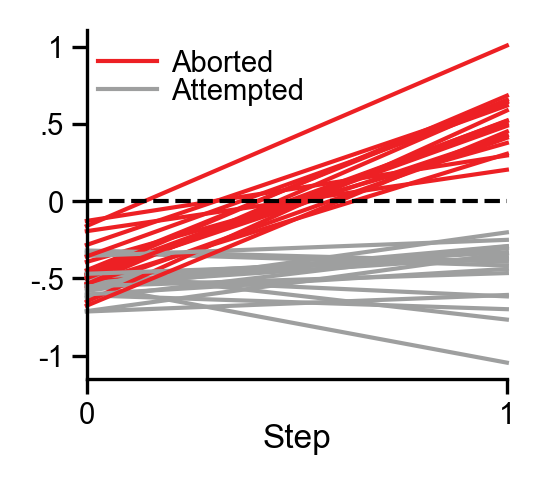

In [18]:
value_no_freeze_skipped = np.vstack([np.hstack(values['no_freeze_skipped'][seed_idx]).mean(axis=1)
                                     for seed_idx in range(len(values['no_freeze_skipped']))]) * 5
value_no_freeze_attempted = np.vstack([np.hstack([v[:2] for v in values['no_freeze_attempted'][seed_idx]]).mean(axis=1)
                                       for seed_idx in range(len(values['no_freeze_attempted']))]) * 5

width = 1.7; height = 1.5

yticks = np.around(np.linspace(-1, 1, 5), 1)
xticks = [0, 1]; xticklabels = ['0', '1']
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
#ax.set_title('No freeze', fontsize=fontsize, pad=0, c=withvalue_c)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'Step', fontsize=fontsize + 1)
ax.set_ylabel('', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
#ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.13)
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

xdata = np.arange(2)
for d1, d2 in zip(value_no_freeze_skipped, value_no_freeze_attempted):
    ax.plot(xdata, d1, lw=lw, clip_on=False, c=abort_c)
    ax.plot(xdata, d2, lw=lw, clip_on=False, c=attempt_c)

ax.plot(xdata, [0, 0], c='k', lw=lw, ls='--')
ax.plot([], [], lw=lw, clip_on=False, c=abort_c, label='Aborted')
ax.plot([], [], lw=lw, clip_on=False, c=attempt_c, label='Attempted')

ax.legend(fontsize=fontsize, frameon=False, loc=[0, 0.75], 
          handletextpad=0.5, labelspacing=0, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='Q_diff_time'), orientation='portrait', format='pdf', transparent=True)

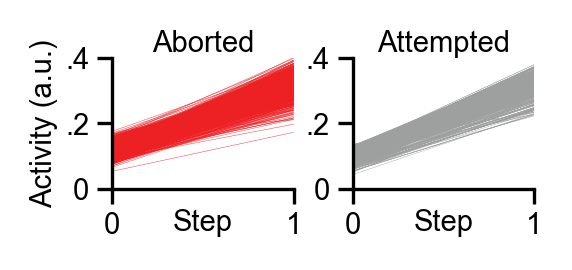

In [19]:
neural_idx = 54
seed = 3

width = 1.8; height = 0.8

yticks = np.around(np.linspace(0, 0.4, 3), 1)
xticks = np.arange(2)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Aborted', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_ylabel('Activity (a.u.)', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.3, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

for v in responses_RNN['no_freeze_skipped'][seed]:
    ax.plot(xticks, v[:, neural_idx], c=abort_c, lw=0.1)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Attempted', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.18, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

for v in responses_RNN['no_freeze_attempted'][seed]:
    ax.plot(xticks, v[:2, neural_idx], c=attempt_c, lw=0.1)

fig.tight_layout(pad=0.3, w_pad=0.1, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='example_RNN_neuron'), orientation='portrait', format='pdf', transparent=True)

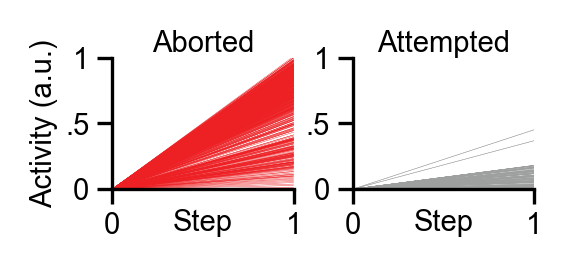

In [20]:
neural_idx = 170
seed = 3

width = 1.8; height = 0.8

yticks = np.around(np.linspace(0, 1, 3), 1)
xticks = np.arange(2)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Aborted', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_ylabel('Activity (a.u.)', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.3, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

for v in responses_actor['no_freeze_skipped'][seed]:
    ax.plot(xticks, v[:, neural_idx], c=abort_c, lw=0.1)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Attempted', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Step', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.18, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

for v in responses_actor['no_freeze_attempted'][seed]:
    ax.plot(xticks, v[:2, neural_idx], c=attempt_c, lw=0.1)

fig.tight_layout(pad=0.3, w_pad=0.1, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='example_actor_neuron'), orientation='portrait', format='pdf', transparent=True)

## 3G

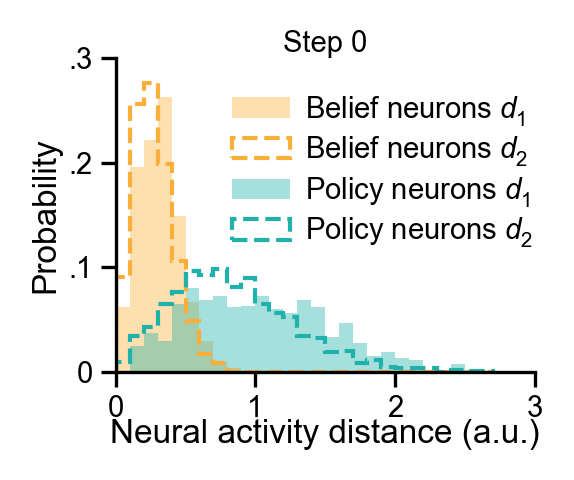

In [21]:
seed_idx = 10; t = 0
response_RNN_diff = [np.linalg.norm(r1[t] - r2[t]) for r1, r2 in zip(responses_RNN['no_freeze_attempted'][seed_idx], 
                                                                     responses_RNN['no_freeze_skipped'][seed_idx])]
response_RNN_diff_c = [np.linalg.norm(r1[t] - r2[t]) for r1, r2 in zip(responses_RNN['no_freeze_skipped_control1'][seed_idx], 
                                                                       responses_RNN['no_freeze_skipped_control2'][seed_idx])]
response_actor_diff = [np.linalg.norm(r1[t] - r2[t]) for r1, r2 in zip(responses_actor['no_freeze_attempted'][seed_idx], 
                                                                       responses_actor['no_freeze_skipped'][seed_idx])]
response_actor_diff_c = [np.linalg.norm(r1[t] - r2[t])
                         for r1, r2 in zip(responses_actor['no_freeze_skipped_control1'][seed_idx], 
                                           responses_actor['no_freeze_skipped_control2'][seed_idx])]

width = 1.8; height = 1.5

yticks = np.around(np.linspace(0, 0.3, 4), 2)
xticks = np.arange(4)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f'Step 0', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Neural activity distance (a.u.)', fontsize=fontsize + 1)
ax.set_ylabel('Probability', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

bins = np.arange(0, 
                 max(np.hstack([response_RNN_diff, response_RNN_diff_c, response_actor_diff, response_actor_diff_c]))
                 + 0.1, 0.1)
weights = np.ones_like(response_RNN_diff) / len(response_RNN_diff)
test = ax.hist(response_RNN_diff, weights=weights, bins=bins,
        alpha=0.4, histtype='bar', color='#faaf3b', label='Belief neurons $d_1$')

weights = np.ones_like(response_RNN_diff_c) / len(response_RNN_diff_c)
ax.hist(response_RNN_diff_c, weights=weights, bins=bins,
        alpha=1, histtype='step', color='#faaf3b', label='Belief neurons $d_2$', ls='--')

weights = np.ones_like(response_actor_diff) / len(response_actor_diff)
ax.hist(response_actor_diff, weights=weights, bins=bins,
        alpha=0.4, histtype='bar', color=withvalue_c, label='Policy neurons $d_1$')

weights = np.ones_like(response_actor_diff_c) / len(response_actor_diff_c)
ax.hist(response_actor_diff_c, weights=weights, bins=bins,
        alpha=1, histtype='step', color=withvalue_c, label='Policy neurons $d_2$', ls='--')

ax.legend(fontsize=fontsize, frameon=False, loc=[0.25, 0.35], 
          handletextpad=0.5, labelspacing=0.2, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='neural_prob_start'), orientation='portrait', format='pdf', transparent=True)

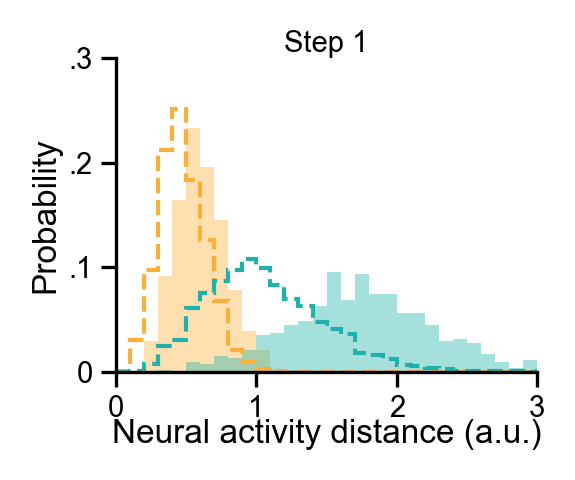

In [22]:
seed_idx = 10; t = 1
response_RNN_diff = [np.linalg.norm(r1[t] - r2[t]) for r1, r2 in zip(responses_RNN['no_freeze_attempted'][seed_idx], 
                                                                     responses_RNN['no_freeze_skipped'][seed_idx])]
response_RNN_diff_c = [np.linalg.norm(r1[t] - r2[t]) for r1, r2 in zip(responses_RNN['no_freeze_skipped_control1'][seed_idx], 
                                                                       responses_RNN['no_freeze_skipped_control2'][seed_idx])]
response_actor_diff = [np.linalg.norm(r1[t] - r2[t]) for r1, r2 in zip(responses_actor['no_freeze_attempted'][seed_idx], 
                                                                       responses_actor['no_freeze_skipped'][seed_idx])]
response_actor_diff_c = [np.linalg.norm(r1[t] - r2[t])
                         for r1, r2 in zip(responses_actor['no_freeze_skipped_control1'][seed_idx], 
                                           responses_actor['no_freeze_skipped_control2'][seed_idx])]

width = 1.8; height = 1.5

yticks = np.around(np.linspace(0, 0.3, 4), 2)
xticks = np.arange(4)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f'Step 1', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Neural activity distance (a.u.)', fontsize=fontsize + 1)
ax.set_ylabel('Probability', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

bins = np.arange(0, 
                 max(np.hstack([response_RNN_diff, response_RNN_diff_c, response_actor_diff, response_actor_diff_c]))
                 + 0.1, 0.1)
weights = np.ones_like(response_RNN_diff) / len(response_RNN_diff)
test = ax.hist(response_RNN_diff, weights=weights, bins=bins,
        alpha=0.4, histtype='bar', color=RNN_c, label='RNN (abor.$-$att.)')

weights = np.ones_like(response_RNN_diff_c) / len(response_RNN_diff_c)
ax.hist(response_RNN_diff_c, weights=weights, bins=bins,
        alpha=1, histtype='step', color=RNN_c, label='RNN (abor.$-$abor.)', ls='--')

weights = np.ones_like(response_actor_diff) / len(response_actor_diff)
ax.hist(response_actor_diff, weights=weights, bins=bins,
        alpha=0.4, histtype='bar', color=withvalue_c, label='Actor (abor.$-$att.)')

weights = np.ones_like(response_actor_diff_c) / len(response_actor_diff_c)
ax.hist(response_actor_diff_c, weights=weights, bins=bins,
        alpha=1, histtype='step', color=withvalue_c, label='Actor (abor.$-$abor.)', ls='--')

#ax.legend(fontsize=fontsize - 1, frameon=False, loc=[0.28, 0.58], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='neural_prob_stop'), orientation='portrait', format='pdf', transparent=True)

meta NOT subset; don't know how to subset; dropped


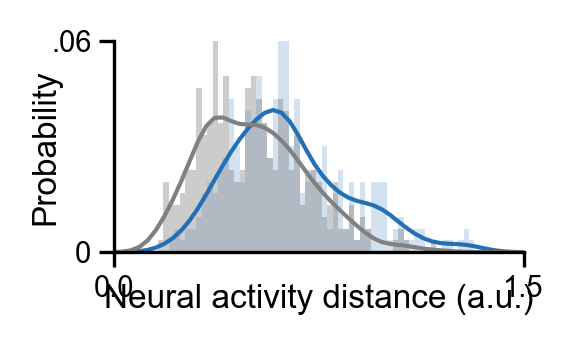

In [223]:
seed_idx = 2; t = 1
response_RNN_diff = [np.linalg.norm(r1[t] - r2[t]) for r1, r2 in zip(responses_RNN['no_freeze_attempted'][seed_idx], 
                                                                     responses_RNN['no_freeze_skipped'][seed_idx])]
response_RNN_diff_c = [np.linalg.norm(r1[t] - r2[t]) for r1, r2 in zip(responses_RNN['no_freeze_skipped_control1'][seed_idx], 
                                                                       responses_RNN['no_freeze_skipped_control2'][seed_idx])]
response_RNN_diff = np.array(response_RNN_diff)[:300]
response_RNN_diff_c = np.array(response_RNN_diff_c)[:300]

width = 1.8; height = 1.05

yticks = np.around(np.linspace(0, 0.06, 2), 2)
xticks = np.around(np.linspace(0, 1.5, 2), 2)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Neural activity distance (a.u.)', fontsize=fontsize + 1)
ax.set_ylabel('Probability', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

binwidth = 0.02
bins = np.arange(0, max(np.hstack([response_RNN_diff, response_RNN_diff_c])) + binwidth, binwidth)
weights = np.ones_like(response_RNN_diff) / len(response_RNN_diff)
ax.hist(response_RNN_diff, weights=weights, bins=bins, alpha=0.2, histtype='barstacked', color='#2270b5')
kde = gaussian_kde(response_RNN_diff)
kde_x = np.linspace(*xticks)
kde_y = kde(kde_x)
ax.plot(kde_x, kde_y * binwidth, lw=lw, c='#2270b5')

weights = np.ones_like(response_RNN_diff_c) / len(response_RNN_diff_c)
ax.hist(response_RNN_diff_c, weights=weights, bins=bins, alpha=0.4, histtype='barstacked', color='gray')
kde = gaussian_kde(response_RNN_diff_c)
kde_x = np.linspace(*xticks)
kde_y = kde(kde_x)
ax.plot(kde_x, kde_y * binwidth, lw=lw, c='gray')

#ax.legend(fontsize=fontsize - 1, frameon=False, loc=[0.28, 0.58], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
#plt.savefig(Path('C:/Users/rz31/Desktop/neuroAI') / '{name}.pdf'.format(
#    name='neural_prob_RNN'), orientation='portrait', format='pdf', transparent=True)

meta NOT subset; don't know how to subset; dropped


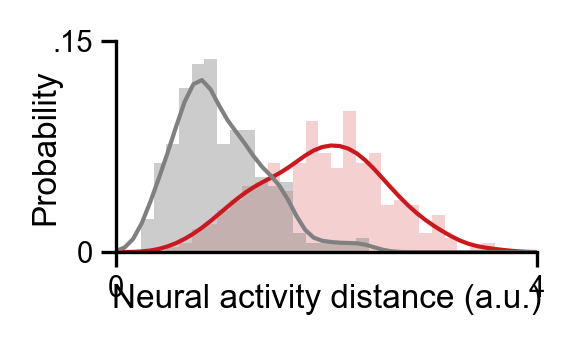

In [224]:
seed_idx = 2; t = 1
response_actor_diff = [np.linalg.norm(r1[t] - r2[t]) for r1, r2 in zip(responses_actor['no_freeze_attempted'][seed_idx], 
                                                                       responses_actor['no_freeze_skipped'][seed_idx])]
response_actor_diff_c = [np.linalg.norm(r1[t] - r2[t])
                         for r1, r2 in zip(responses_actor['no_freeze_skipped_control1'][seed_idx], 
                                           responses_actor['no_freeze_skipped_control2'][seed_idx])]
response_actor_diff = np.array(response_actor_diff)[:300]
response_actor_diff_c = np.array(response_actor_diff_c)[:300]

width = 1.8; height = 1.05

yticks = np.around(np.linspace(0, 0.15, 2), 2)
xticks = np.around(np.linspace(0, 4, 2), 2)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Neural activity distance (a.u.)', fontsize=fontsize + 1)
ax.set_ylabel('Probability', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

binwidth = 0.12
bins = np.arange(0, max(np.hstack([response_actor_diff, response_actor_diff_c])) + binwidth, binwidth)
weights = np.ones_like(response_actor_diff) / len(response_actor_diff)
ax.hist(response_actor_diff, weights=weights, bins=bins, alpha=0.2, histtype='barstacked', color='#cb171d')
kde = gaussian_kde(response_actor_diff)
kde_x = np.linspace(*xticks)
kde_y = kde(kde_x)
ax.plot(kde_x, kde_y * binwidth, lw=lw, c='#cb171d')

weights = np.ones_like(response_actor_diff_c) / len(response_actor_diff_c)
ax.hist(response_actor_diff_c, weights=weights, bins=bins, alpha=0.4, histtype='barstacked', color='gray')
kde = gaussian_kde(response_actor_diff_c)
kde_x = np.linspace(*xticks)
kde_y = kde(kde_x)
ax.plot(kde_x, kde_y * binwidth, lw=lw, c='gray')

#ax.legend(fontsize=fontsize - 1, frameon=False, loc=[0.28, 0.58], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
#plt.savefig(Path('C:/Users/rz31/Desktop/neuroAI') / '{name}.pdf'.format(
#    name='neural_prob_actor'), orientation='portrait', format='pdf', transparent=True)

## 3H

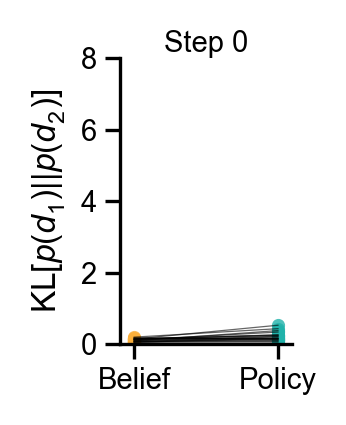

In [23]:
t = 0
KL_RNNs = []; KL_actors = []
seeds_num = len(responses_RNN['no_freeze_attempted'])
for seed_idx in range(seeds_num):
    response_RNN_diff = [np.linalg.norm(r1[t] - r2[t]) 
                         for r1, r2 in zip(responses_RNN['no_freeze_attempted'][seed_idx], 
                                           responses_RNN['no_freeze_skipped'][seed_idx])]
    response_RNN_diff_c = [np.linalg.norm(r1[t] - r2[t]) 
                           for r1, r2 in zip(responses_RNN['no_freeze_skipped_control1'][seed_idx], 
                                             responses_RNN['no_freeze_skipped_control2'][seed_idx])]
    response_actor_diff = [np.linalg.norm(r1[t] - r2[t]) 
                           for r1, r2 in zip(responses_actor['no_freeze_attempted'][seed_idx], 
                                             responses_actor['no_freeze_skipped'][seed_idx])]
    response_actor_diff_c = [np.linalg.norm(r1[t] - r2[t])
                             for r1, r2 in zip(responses_actor['no_freeze_skipped_control1'][seed_idx], 
                                               responses_actor['no_freeze_skipped_control2'][seed_idx])]
    
    bins = np.arange(0, 
                     max(np.hstack([response_RNN_diff, response_RNN_diff_c, response_actor_diff, response_actor_diff_c]))
                     + 0.1, 
                     0.1)
    response_RNN_diff, _ = np.histogram(response_RNN_diff, bins=bins)
    response_RNN_diff = response_RNN_diff + 1e-10
    response_RNN_diff = response_RNN_diff / response_RNN_diff.sum()
    
    response_RNN_diff_c, _ = np.histogram(response_RNN_diff_c, bins=bins)
    response_RNN_diff_c = response_RNN_diff_c + 1e-10
    response_RNN_diff_c = response_RNN_diff_c / response_RNN_diff_c.sum()
    
    response_actor_diff, _ = np.histogram(response_actor_diff, bins=bins)
    response_actor_diff = response_actor_diff + 1e-10
    response_actor_diff = response_actor_diff / response_actor_diff.sum()

    response_actor_diff_c, _ = np.histogram(response_actor_diff_c, bins=bins)
    response_actor_diff_c = response_actor_diff_c + 1e-10
    response_actor_diff_c = response_actor_diff_c / response_actor_diff_c.sum()
    
    KL_RNNs.append(entropy(response_RNN_diff, response_RNN_diff_c))
    KL_actors.append(entropy(response_actor_diff, response_actor_diff_c))

width = 1.1; height = 1.3

yticks = np.around(np.arange(0, 9, 2), 1)
xticks = np.arange(2); xticklabels = ['Belief', 'Policy']
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f'Step 0', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize + 1)
ax.set_ylabel('KL[$p(d_1)||p(d_2)$]', fontsize=fontsize + 1)
ax.set_xlim(xticks[0]-0.1, xticks[-1]+0.1)
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.2)
ax.yaxis.set_label_coords(-0.3, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

ax.scatter([0] * seeds_num, KL_RNNs, c=RNN_c, alpha=0.8, s=10, lw=0)
ax.scatter([1] * seeds_num, KL_actors, c=withvalue_c, alpha=0.8, s=10, lw=0)
for seed_idx in range(seeds_num):
    ax.plot([0, 1], [KL_RNNs[seed_idx], KL_actors[seed_idx]], lw=lw * 0.3, c='k', alpha=0.6)
#ax.plot([0, 1], [np.mean(KL_RNNs), np.mean(KL_actors)], lw=lw, c='k')

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='neural_KL_start'), orientation='portrait', format='pdf', transparent=True)

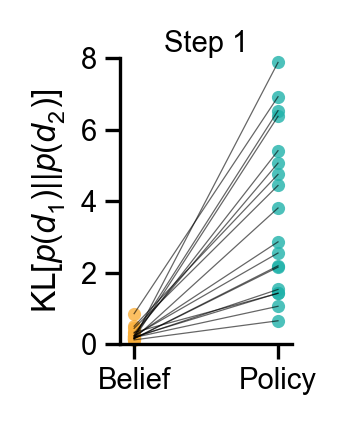

In [24]:
t = 1
KL_RNNs = []; KL_actors = []
seeds_num = len(responses_RNN['no_freeze_attempted'])
for seed_idx in range(seeds_num):
    response_RNN_diff = [np.linalg.norm(r1[t] - r2[t]) 
                         for r1, r2 in zip(responses_RNN['no_freeze_attempted'][seed_idx], 
                                           responses_RNN['no_freeze_skipped'][seed_idx])]
    response_RNN_diff_c = [np.linalg.norm(r1[t] - r2[t]) 
                           for r1, r2 in zip(responses_RNN['no_freeze_skipped_control1'][seed_idx], 
                                             responses_RNN['no_freeze_skipped_control2'][seed_idx])]
    response_actor_diff = [np.linalg.norm(r1[t] - r2[t]) 
                           for r1, r2 in zip(responses_actor['no_freeze_attempted'][seed_idx], 
                                             responses_actor['no_freeze_skipped'][seed_idx])]
    response_actor_diff_c = [np.linalg.norm(r1[t] - r2[t])
                             for r1, r2 in zip(responses_actor['no_freeze_skipped_control1'][seed_idx], 
                                               responses_actor['no_freeze_skipped_control2'][seed_idx])]
    
    bins = np.arange(0, 
                     max(np.hstack([response_RNN_diff, response_RNN_diff_c, response_actor_diff, response_actor_diff_c]))
                     + 0.1, 
                     0.1)
    response_RNN_diff, _ = np.histogram(response_RNN_diff, bins=bins)
    response_RNN_diff = response_RNN_diff + 1e-10
    response_RNN_diff = response_RNN_diff / response_RNN_diff.sum()
    
    response_RNN_diff_c, _ = np.histogram(response_RNN_diff_c, bins=bins)
    response_RNN_diff_c = response_RNN_diff_c + 1e-10
    response_RNN_diff_c = response_RNN_diff_c / response_RNN_diff_c.sum()
    
    response_actor_diff, _ = np.histogram(response_actor_diff, bins=bins)
    response_actor_diff = response_actor_diff + 1e-10
    response_actor_diff = response_actor_diff / response_actor_diff.sum()

    response_actor_diff_c, _ = np.histogram(response_actor_diff_c, bins=bins)
    response_actor_diff_c = response_actor_diff_c + 1e-10
    response_actor_diff_c = response_actor_diff_c / response_actor_diff_c.sum()
    
    KL_RNNs.append(entropy(response_RNN_diff, response_RNN_diff_c))
    KL_actors.append(entropy(response_actor_diff, response_actor_diff_c))

width = 1.1; height = 1.3

yticks = np.around(np.arange(0, 9, 2), 1)
xticks = np.arange(2); xticklabels = ['Belief', 'Policy']
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f'Step 1', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize + 1)
ax.set_ylabel('KL[$p(d_1)||p(d_2)$]', fontsize=fontsize + 1)
ax.set_xlim(xticks[0]-0.1, xticks[-1]+0.1)
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.2)
ax.yaxis.set_label_coords(-0.3, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

ax.scatter([0] * seeds_num, KL_RNNs, c=RNN_c, alpha=0.8, s=10, lw=0, clip_on=False)
ax.scatter([1] * seeds_num, KL_actors, c=withvalue_c, alpha=0.8, s=10, lw=0, clip_on=False)
for seed_idx in range(seeds_num):
    ax.plot([0, 1], [KL_RNNs[seed_idx], KL_actors[seed_idx]], lw=lw * 0.3, c='k', alpha=0.6)
#ax.plot([0, 1], [np.mean(KL_RNNs), np.mean(KL_actors)], lw=lw, c='k')

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='neural_KL_stop'), orientation='portrait', format='pdf', transparent=True)